In [143]:
import numpy as np
import pandas as pd
import os
import random
import h5py
import torch
import torch.nn as nn
import jax

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from torch.utils.data import DataLoader, TensorDataset

import numpyro
import numpy as np 
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

sun_numax = 3090

## Neural network 

In [146]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  
            nn.ReLU(),
            nn.Linear(256, 256),  # 2
            nn.ReLU(),
            nn.Linear(256, 256),  # 3
            nn.ReLU(),
            nn.Linear(256, 256),  # 4
            nn.ReLU(),
            nn.Linear(256, 256),  # 5
            nn.ReLU(),
            nn.Linear(256, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
ckpt_path = "best_model_v8-1-epoch=9965-val_loss=0.0071.ckpt"
input_dim = 7  # Number of input features
output_dim = 5  # Number of output features
model = GarstecNet.load_from_checkpoint(ckpt_path, input_dim=input_dim, output_dim=output_dim)
device = torch.device("cpu")
model.to(device)
model.eval()  

GarstecNet(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=5, bias=True)
  )
  (criterion): MSELoss()
)

## Importing scaling relations

In [ ]:
import joblib

scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

## Extracting data for specific track

In [ ]:
import jax.numpy as jnp

# Plotting for neural network and garstec track: 07294
specific_track_name = 'track07294'

# Retrieve all required inputs for track: 07294
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    age_07294 = specific_track['age'][:].reshape(-1, 1)
    massini_07294 = specific_track['massini'][:].reshape(-1, 1)
    fehini_07294 = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt_07294 = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini_07294 = specific_track['yini'][:].reshape(-1, 1)
    eta_07294 = specific_track['eta'][:].reshape(-1, 1)
    alphafe_07294 = specific_track['alphaFe'][:].reshape(-1, 1)

    # Retrieve actual values for plotting
    teff_07294 = specific_track['Teff'][:]
    luminosity_07294 = specific_track['LPhot'][:]
    dnufit_07294 = specific_track['dnufit'][:]
    FeH_07294 = specific_track['FeH'][:]
    numax_07294 = specific_track['numax'][:]

# Printing values for testing:

print(teff_07294[0])
print(luminosity_07294[0])
print(dnufit_07294[0])
print(FeH_07294[0])
print(numax_07294[0])

6837.218056
11.162520930837232
37.47918006563131
-1.1553955077842843
0.178603010181


## Emulate function for Bayesian model

In [149]:
state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]
    return x

=== Prior Samples ===
ages_: 5105.733
massini_: 1.1314435
fehini_: -0.99148166
alphamlt_: 2.0051208
yini_: 0.3002631
eta_: 0.1279136
alphafe_: 0.26543534

=== Prior Samples ===
ages_: 6864.0938
massini_: 1.0139389
fehini_: -1.1019497
alphamlt_: 1.8790736
yini_: 0.27831522
eta_: 0.13537666
alphafe_: 0.30761313

=== Actual Values ===

age: 4145.349646
mass: 1.107
alphamlt: 2.02275391
eta: 0.03665771
yini: 0.24572388
fehini: -1.15539551
alphafe: -0.2

* Prior for alphafe has now been changed to represent values.

In [ ]:
epsilon = 1e-10

log_vars_inputs = [age_07294, massini_07294, alphamlt_07294, eta_07294, yini_07294] 
log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
x = jnp.hstack(log_transformed_inputs + [fehini_07294, alphafe_07294])

print('age', age_07294[0])
print('mass', massini_07294[0])
print('alphamlt', alphamlt_07294[0])
print('eta', eta_07294[0])
print('yini', yini_07294[0])
print('fehini', fehini_07294[0])
print('alphafe', alphafe_07294[0])


# Scale x manually
mean_x = scaler_X.mean_
scale_x = scaler_X.scale_  
x_scaled = (x - mean_x) / scale_x

# Emulate using PyTorch model
y_scaled = emulate(x_scaled)
    
# De-scale y manually 
mean_y = jnp.array(scaler_y.mean_)  
std_y = jnp.array(scaler_y.scale_)
y = y_scaled * std_y + mean_y

teff_test = jnp.power(10.0, y[..., 0])
lum_test = jnp.power(10.0, y[..., 1])

age [4145.349646]
mass [1.107]
alphamlt [2.02275391]
eta [0.03665771]
yini [0.24572388]
fehini [-1.15539551]
alphafe [-0.2]


In [151]:
obs = {
    'teff': [teff_07294],
    'lum': [luminosity_07294],
    'dnu': [dnufit_07294],
    'feh': [FeH_07294],
    'numax': [numax_07294 * sun_numax],
}

obs_err = {
    'teff_err': [70],
    'lum_err': [10],
    'dnu_err': [2],
    'feh_err': [0.1],
    'numax_err': [3]
}

## Bayesian model

In [183]:
def Bmodel(obs=None):
    # Define priors
    ages_ = numpyro.deterministic("ages_", 15000* numpyro.sample("ages_s", dist.Beta(2, 2)))
    massini_ = numpyro.deterministic("massini_", 0.8 * numpyro.sample("massini_s", dist.Beta(2, 2)) + 0.7)
    fehini_ = numpyro.deterministic("fehini_", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2.0)
    alphamlt_ = numpyro.deterministic("alphamlt_", 0.8 * numpyro.sample("alphamlt_s", dist.Beta(2, 2)) + 1.5)
    yini_ = numpyro.deterministic("yini_", 0.13 * numpyro.sample("yini_s", dist.Beta(2, 2)) + 0.22)
    eta_ = numpyro.deterministic("eta_", 0.3 * numpyro.sample("eta_s", dist.Beta(2, 2)))
    alphafe_ = numpyro.deterministic("alphafe_", 0.08 * numpyro.sample("alphafe_s", dist.Beta(2, 2)) - 0.24) 


    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, yini_] 
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
    x = jnp.hstack(log_transformed_inputs + [fehini_, alphafe_])

    # Scale x manually
    mean_x = scaler_X.mean_
    scale_x = scaler_X.scale_  
    x_scaled = (x - mean_x) / scale_x

    # Emulate using PyTorch model
    y_scaled = emulate(x_scaled)
    
    # De-scale y manually 
    mean_y = jnp.array(scaler_y.mean_)  
    std_y = jnp.array(scaler_y.scale_)
    y = y_scaled * std_y + mean_y
    
    # Extract predictions
    teff = numpyro.deterministic("teff", jnp.power(10.0, y[..., 0])) # jnp.power(10.0, y[..., 0])
    lum = numpyro.deterministic("lum", jnp.power(10.00, y[..., 1])) 
    dnu = numpyro.deterministic("dnu", jnp.power(10.0, y[..., 2]))
    numax = numpyro.deterministic("numax", jnp.power(10.0, y[..., 3]) * sun_numax)
    feh = numpyro.deterministic("feh", y[..., 4])

    
    # Observational likelihoods
    if obs is not None:
        numpyro.sample("teff_obs", dist.StudentT(5, teff, obs_err['teff_err'][0]), obs=obs['teff'][0])
        numpyro.sample("lum_obs", dist.StudentT(5, lum, obs_err['lum_err'][0]), obs=obs['lum'][0])
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, obs_err['dnu_err'][0]), obs=obs['dnu'][0])
        numpyro.sample("feh_obs", dist.StudentT(5, feh, obs_err['feh_err'][0]), obs=obs['feh'][0])
        numpyro.sample("numax_obs", dist.StudentT(5, numax, obs_err['numax_err'][0]), obs=obs['numax'][0])

## Prior predictive

In [153]:
from jax import random

nuts_kernel = NUTS(Bmodel)

prior_mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
prior_mcmc.run(rng_key)

posterior_samples = prior_mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:15<00:00, 265.75it/s, 7 steps of size 5.79e-01. acc. prob=0.92] 


c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\Dell\miniconda3\Lib\site-packages\arviz\stats\density_utils.py:707: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) / 2
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step


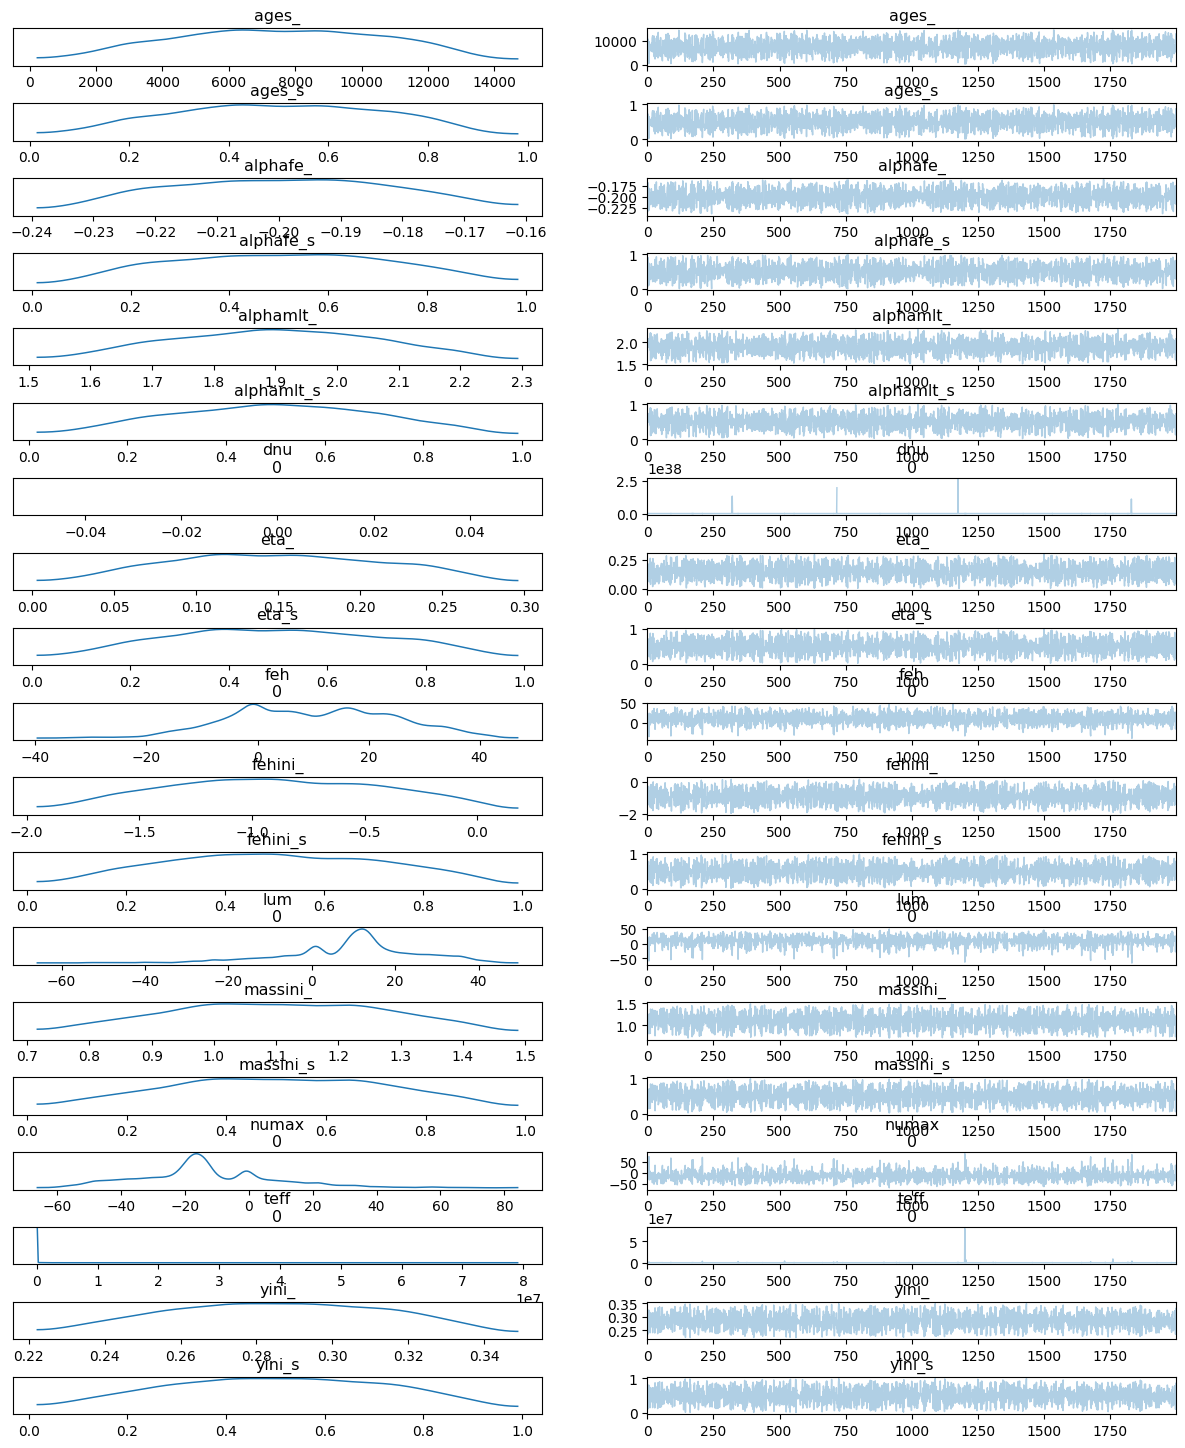

In [154]:
import arviz as az

prior_trace = az.from_numpyro(prior_mcmc)
az.plot_trace(prior_trace, compact=False, figsize=(15, 18));  

plt.subplots_adjust(hspace=1)  

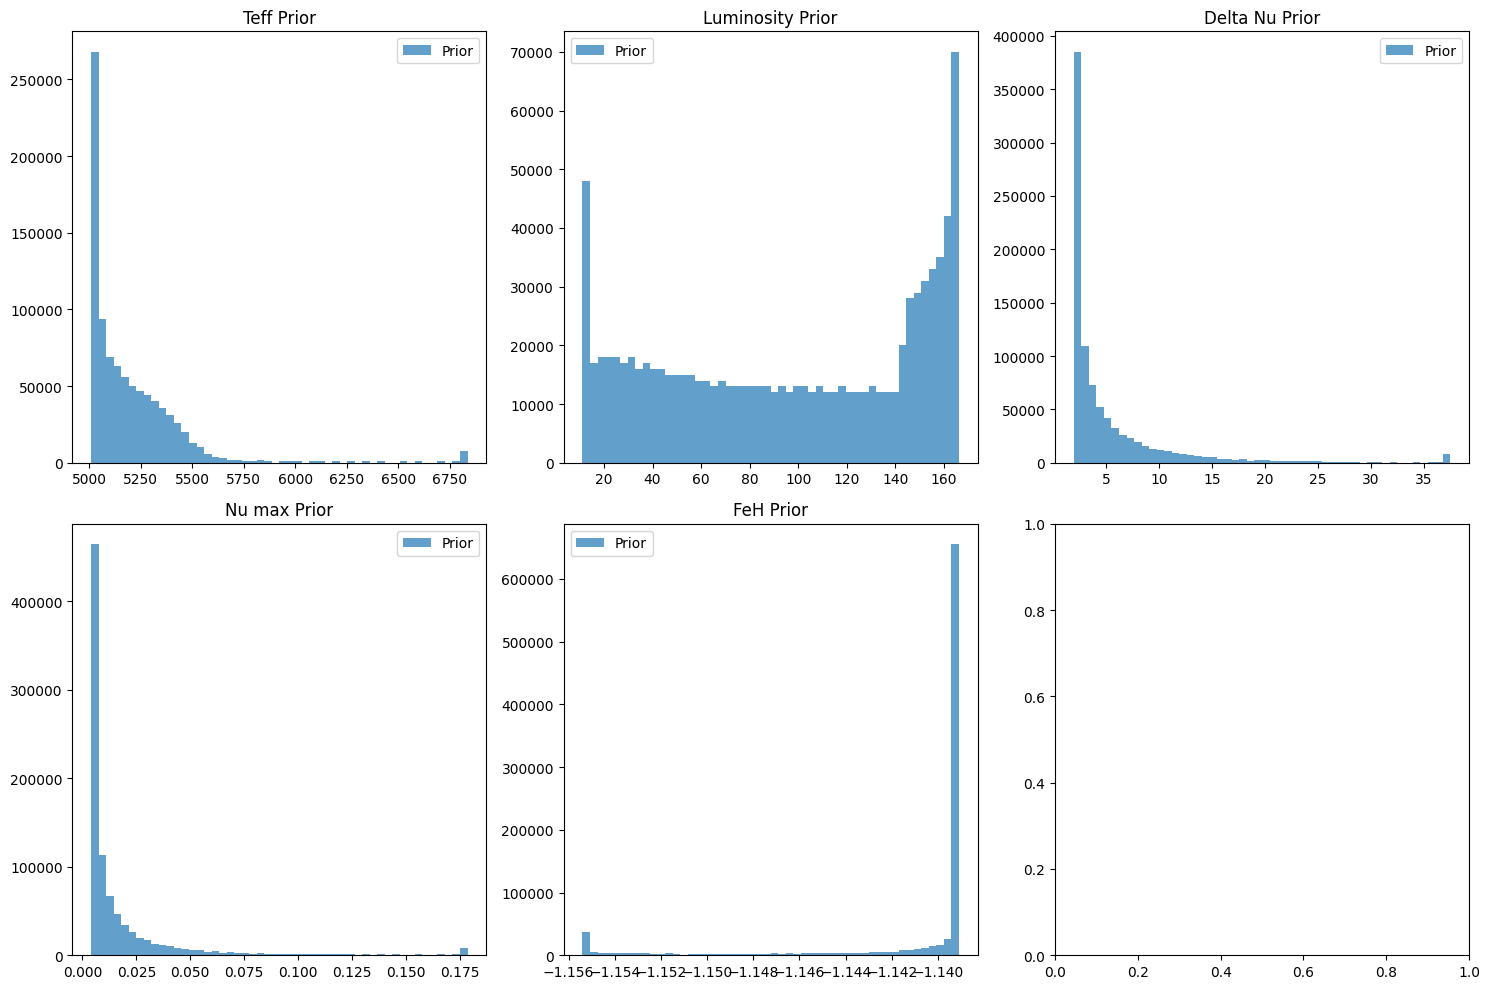

In [155]:
# Run observables predictive
prior_predictive = numpyro.infer.Predictive(Bmodel, num_samples=1000)
prior_samples = prior_predictive(rng_key=random.PRNGKey(0), obs=1)

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Function to remove infinite and nan values and plot histogram
def hist(ax, data, title, observed=None, bins=50):
    # Remove inf and nan values
    data = data[~jnp.isinf(data)]
    data = data[~jnp.isnan(data)]
    
    if data.size > 0:
        ax.hist(data, bins=bins, alpha=0.7, label='Prior')
        
        if observed is not None:
            observed = observed[~jnp.isinf(observed)]
            observed = observed[~jnp.isnan(observed)]
        
        ax.set_title(title)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center')

# Plot histograms
hist(axes[0], (prior_samples['teff_obs']), 'Teff Prior', teff_07294)
hist(axes[1], (prior_samples['lum_obs']), 'Luminosity Prior', luminosity_07294)
hist(axes[2], (prior_samples['dnu_obs']), 'Delta Nu Prior', dnufit_07294)
hist(axes[3], (prior_samples['numax_obs']), 'Nu max Prior', numax_07294)
hist(axes[4], prior_samples['feh_obs'], 'FeH Prior', FeH_07294)

plt.tight_layout()
plt.show()

## Running model and Posterior plotting 

In [156]:
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=4) # between 1000 and 4000 for testing 
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=obs)

C:\Users\Dell\AppData\Local\Temp\ipykernel_49524\1939386306.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=4) # between 1000 and 4000 for testing
sample: 100%|██████████| 2000/2000 [04:32<00:00,  7.33it/s, 1023 steps of size 5.65e-04. acc. prob=0.84]


In [157]:
trace = az.from_numpyro(mcmc)

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_,3491.951,3081.419,1350.934,9320.806,1532.277,1172.932,5.0,11.0,2.66
ages_s,0.233,0.205,0.090,0.621,0.102,0.078,5.0,11.0,2.66
alphafe_,-0.203,0.013,-0.228,-0.173,0.002,0.001,39.0,163.0,1.69
alphafe_s,0.461,0.167,0.154,0.842,0.024,0.022,39.0,163.0,1.69
alphamlt_,1.658,0.158,1.501,1.955,0.078,0.060,5.0,11.0,2.79
alphamlt_s,0.197,0.197,0.002,0.568,0.097,0.075,5.0,11.0,2.79
dnu[0],4.371,2.525,0.000,5.983,1.257,0.963,6.0,11.0,1.88
eta_,0.061,0.057,0.000,0.120,0.027,0.021,6.0,31.0,2.35
eta_s,0.203,0.190,0.000,0.401,0.090,0.068,6.0,31.0,2.35
feh[0],1.548,4.663,-1.149,9.998,2.321,1.777,7.0,11.0,1.60


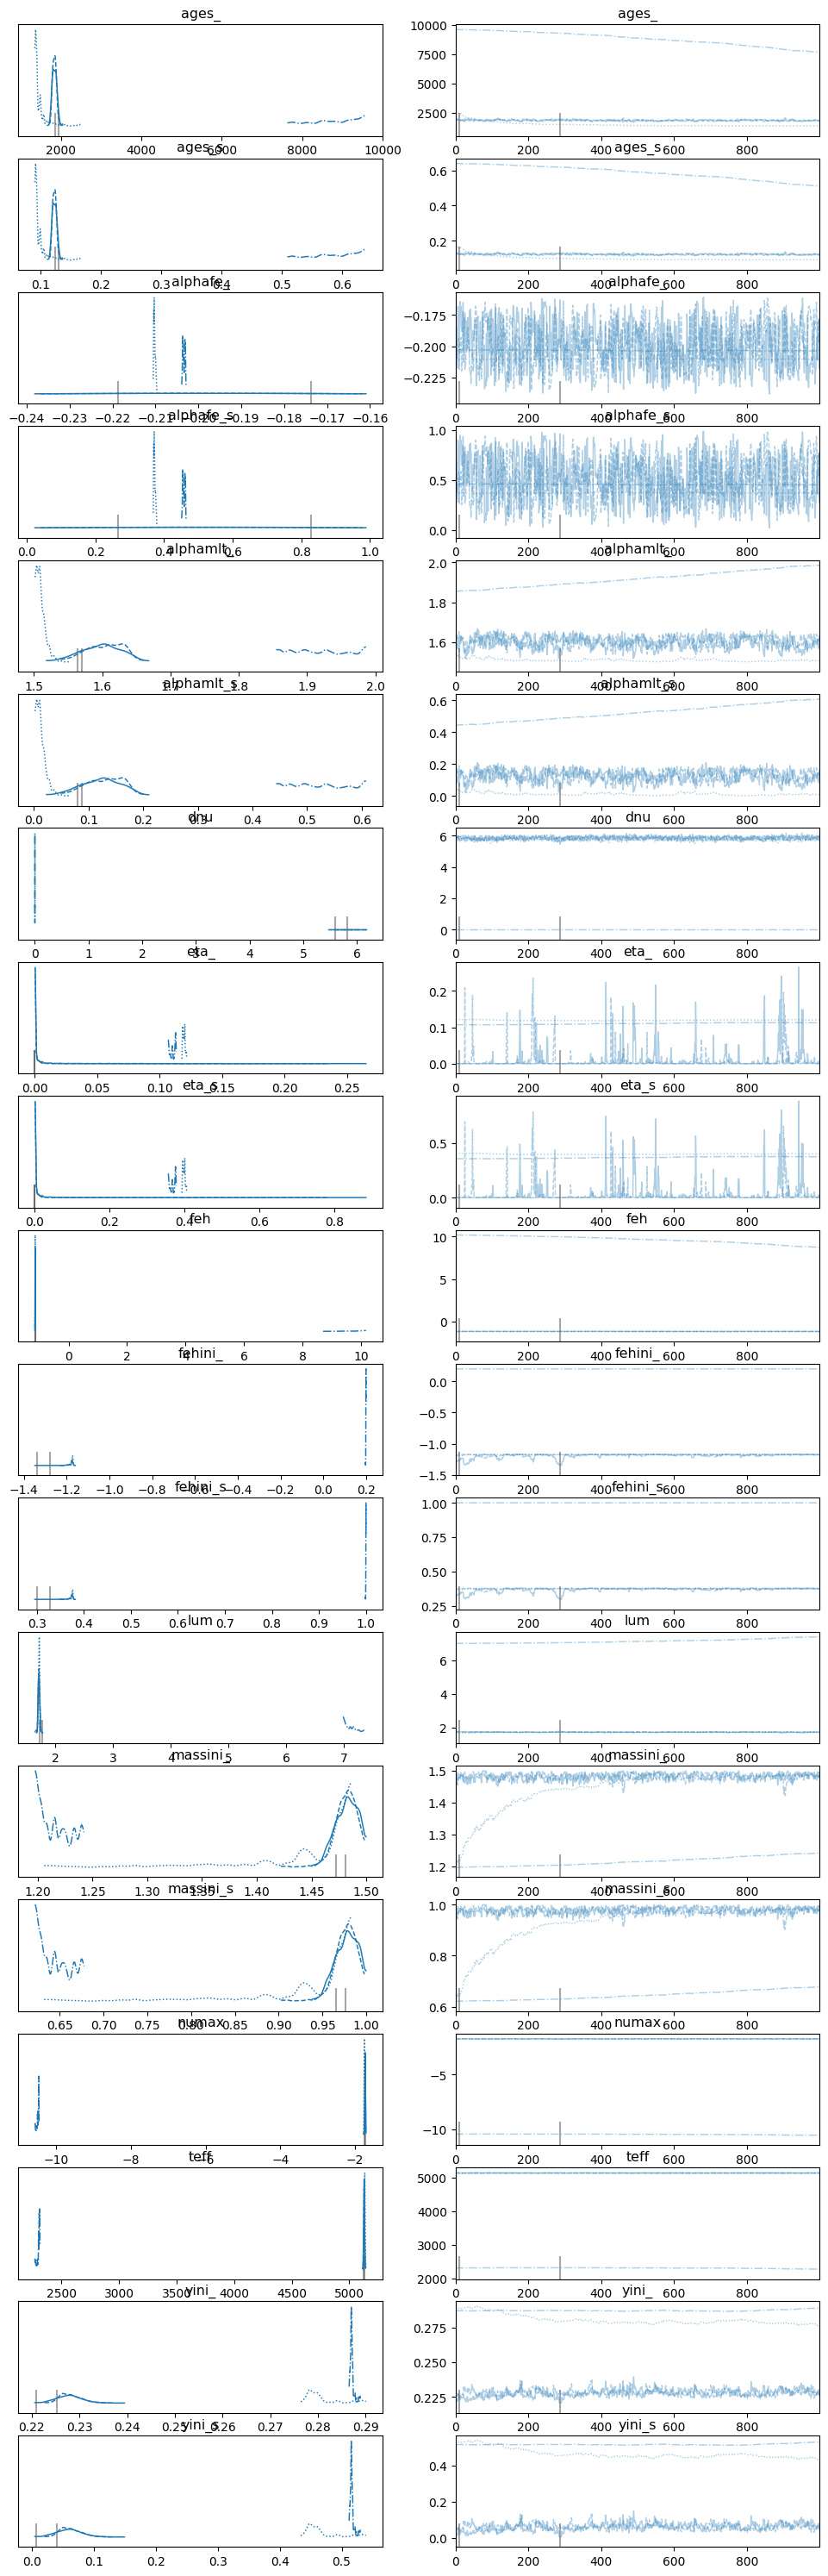

In [162]:
az.plot_trace(trace);

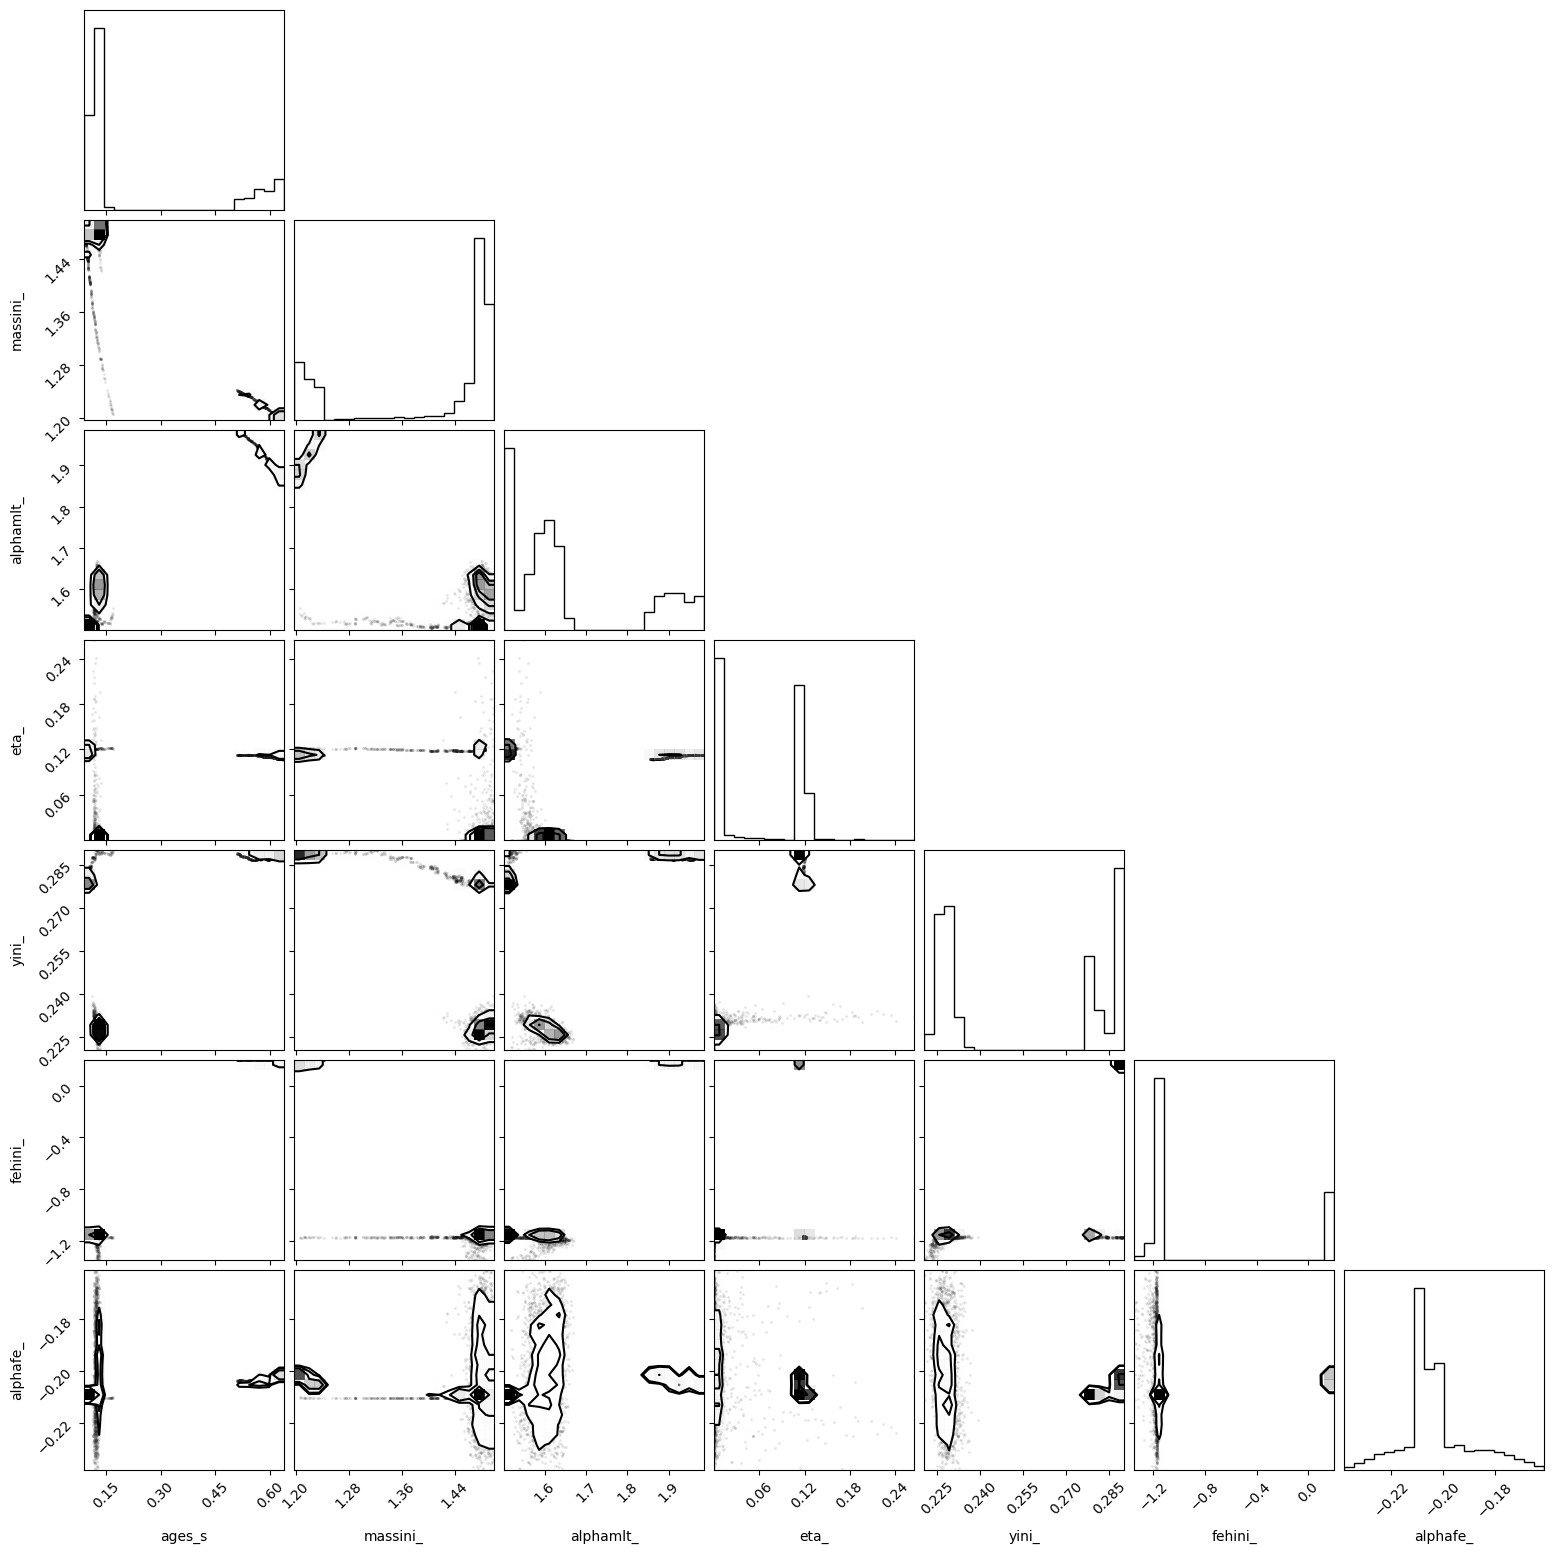

In [163]:
# Setting truth values for corner plot
#truth_values = [ages[0].item(), massini[0].item(), alphamlt[0].item(), eta[0].item(), yini[0].item(),  fehini[0].item(), alphafe[0].item()]
#print(truth_values)
import corner

corner.corner(trace, var_names=['ages_s', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             );

In [181]:
from sklearn.preprocessing import MinMaxScaler


# Extract the variables from the trace
ages_samples = trace.posterior['ages_s'].values.flatten()
mass_samples = trace.posterior['massini_'].values.flatten()
mlt_samples = trace.posterior['alphamlt_'].values.flatten()
eta_samples = trace.posterior['eta_'].values.flatten()
yini_samples = trace.posterior['yini_'].values.flatten()
fehini_samples = trace.posterior['fehini_'].values.flatten()
fe_samples = trace.posterior['alphafe_'].values.flatten()

# sample 910 values from the model:

# Length of the ages_samples
n_samples = len(ages_samples)

# Indices of the minimum and maximum values
min_idx = np.argmin(ages_samples)
max_idx = np.argmax(ages_samples)

# If ages_samples is long enough, divide the remaining range into even intervals
# Calculate the total number of intervals (excluding the min and max)
num_intervals = 910 - 2  # Subtract 2 because min and max are already selected

# Calculate step size for evenly spaced sampling
step = (n_samples - 1) // num_intervals  # This will give us roughly equal intervals

# Generate the indices for evenly spaced sampling, including min and max
evenly_spaced_indices = [min_idx, max_idx]  # Start with min and max indices
for i in range(1, num_intervals + 1):
    idx = i * step
    evenly_spaced_indices.append(idx)

# Sort the indices to ensure they're in ascending order
ages_indices = np.sort(evenly_spaced_indices)

# Subsample all variables
ages_subsample = np.sort(ages_samples[ages_indices]).reshape(-1, 1)
mass_subsample = np.full(910, np.mean(mass_samples)).reshape(-1, 1)
mlt_subsample = np.full(910, np.mean(mlt_samples)).reshape(-1, 1)
eta_subsample = np.full(910, np.mean(eta_samples)).reshape(-1, 1)
yini_subsample = np.full(910, np.mean(yini_samples)).reshape(-1, 1)
fehini_subsample = np.full(910, np.mean(fehini_samples)).reshape(-1, 1)
fe_subsample = np.full(910, np.mean(fe_samples)).reshape(-1, 1)

epsilon = 1e-10
log10_hbm_inputs = [ages_subsample, mass_subsample, mlt_subsample, eta_subsample, yini_subsample] 
log10_transformed_hbm_inputs = [np.log10(np.maximum(data, epsilon)) for data in log10_hbm_inputs]

# Combine log-transformed inputs with raw `fehini` and `yini`
features = np.hstack(log10_transformed_hbm_inputs + [fehini_subsample, fe_subsample])

features_numpy = np.array(features)  # Convert to numpy for scaling

features_scaled = scaler_X.transform(features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor

features_tensor = torch.FloatTensor(features_scaled)

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Dell\AppData\Local\Temp\ipykernel_49524\761509579.py:26: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
C:\Users\Dell\AppData\Local\Temp\ipykernel_49524\761509579.py:27: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(f"Log Luminosity ($\log(L_\odot)$)")


[234.28262 234.27492 234.24332 234.23495 234.21094 234.19234 234.1853
 234.16695 234.15279 234.1503  234.12906 234.12785 234.12466 234.12256
 234.09875 234.09528 234.09451 234.09225 234.08516 234.07455 234.06812
 234.0622  234.0612  234.06114 234.057   234.05505 234.04305 234.03098
 234.02605 234.02258 234.02223 234.0204  234.00719 233.99982 233.99515
 233.98299 233.97945 233.96901 233.96265 233.95769 233.95537 233.952
 233.94873 233.94649 233.9429  233.94173 233.93909 233.93587 233.9284
 233.92805 233.92473 233.92044 233.91809 233.91759 233.91743 233.91559
 233.91144 233.91113 233.9043  233.895   233.895   233.8926  233.87872
 233.8768  233.86185 233.86131 233.85773 233.84763 233.83534 233.83098
 233.82913 233.82835 233.8191  233.81772 233.80157 233.7706  233.74101
 233.72102 233.71324 233.70961 233.70605 233.67242 233.65    233.64992
 233.63637 233.6204  233.61777 233.60596 233.60594 233.60112 233.59563
 233.58974 233.57649 233.5594  233.55664 233.54576 233.53757 233.53284
 233.5104 

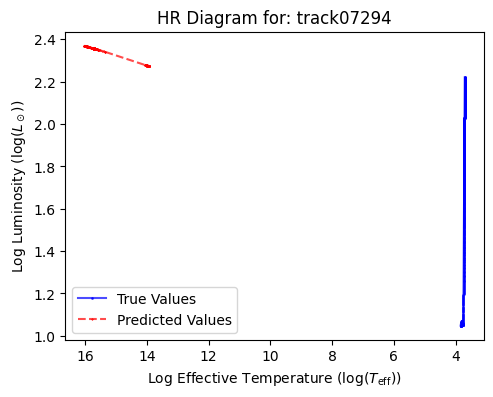

In [ ]:
model.eval()
with torch.no_grad():
    predictions_hbm = model(features_tensor).numpy()  # Make predictions
    predictions_hbm1 = scaler_y.inverse_transform(predictions_hbm)  # Inverse transform

# Extract predicted `Teff` and `Luminosity`
hbm_teff = 10**predictions_hbm1[:, 0]  # Inverse log10 transformation
hbm_luminosity = 10**predictions_hbm1[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_07294)
log_actual_luminosity = np.log10(luminosity_07294)

# Log-transform predicted values for plotting
log_hbm_teff = np.log10(hbm_teff)
log_hbm_luminosity = np.log10(hbm_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(5.4, 4))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_hbm_teff, log_hbm_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel(f"Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()